# Machine Learning for Networking - Group Project 5 - DDoS attacks detection and characterization - Section 3 & 4
# Preliminaries operations

## Import needed libraries

In [9]:
#Import needed libraries
! pip3 install shap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap



## Data preparation & standardization

In [10]:
columns_to_remove = ['Active Mean', 'Active Std', 'Average Packet Size', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size',
                     'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                     'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Packets/s',
                     'Fwd Header Length', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Total',
                     'Fwd PSH Flags', 'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Idle Max', 'Idle Mean',
                     'Min Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
                     'Protocol', 'Subflow Bwd Bytes', 'Subflow Bwd Packets', 'Subflow Fwd Bytes', 'Subflow Fwd Packets',
                     'Total Backward Packets', 'Total Length of Bwd Packets', 'Total Length of Fwd Packets']

ddos_data = pd.read_csv("ddos_dataset.csv", sep=",")
ddos_data.rename(columns=lambda x: x.strip(), inplace=True)
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].apply(lambda x: str(x) if x == 0 else x)
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].str.strip().fillna(0, inplace=True)
ddos_data = ddos_data.drop(columns=columns_to_remove, errors='ignore')

Columns (85) have mixed types.Specify dtype option on import or set low_memory=False.


In [11]:
#standardize
# Get X and y
ddos_data.drop(columns=["Unnamed: 0", "Destination IP", "Source IP", "Timestamp", "SimillarHTTP"], axis=1, inplace=True)
ddos_data_original = ddos_data.copy()
ddos_data = ddos_data.set_index('Flow ID')
X = ddos_data.drop(columns=['label']).to_numpy()
y = ddos_data[['label']].values

# Scale Data
scaler = StandardScaler()
X_s = scaler.fit_transform(X)

#PCA
pca = PCA(n_components=9, random_state=15)
X_s = pca.fit_transform(X_s)


# Section 3

The aim of this section is to find the best clustering algorithm with the best $k$.

## 1 Unsupervised Learning: K-means attempt
First of all, we define a function to perform k-means clustering and store metrics


In [12]:
def perform_kmeans_clustering(n_clusters, X_s, y):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cl_labels = kmeans.fit_predict(X_s)
    silhouette = silhouette_score(X_s, cl_labels)
    ri = rand_score(np.ravel(y), cl_labels)
    ari = adjusted_rand_score(np.ravel(y), cl_labels)
    inertia = kmeans.inertia_
    return n_clusters, silhouette, ri, ari, inertia, cl_labels

In [13]:
%%time

# Arrays init
n_cluster_list_kmeans = []
shs_list_kmeans = []
ri_list_kmeans = []
ari_list_kmeans = []
inertia_list_kmeans = []

# Define a range of n_clusters for the initial broader search
initial_range = range(3, 16, 3)

# Use Parallel and delayed to parallelize the loop
results_kmeans = Parallel(n_jobs=-1)(
    delayed(perform_kmeans_clustering)(n_clusters, X_s, y) for n_clusters in initial_range)

# Extract the results into separate lists
n_cluster_list_kmeans, shs_list_kmeans, ri_list_kmeans, ari_list_kmeans, inertia_list_kmeans, tmp_kmeans = zip(
    *results_kmeans)

# Get n_clusters leading to the highest silhouette
best_sh_kmeans = np.max(shs_list_kmeans)
best_n_kmeans = n_cluster_list_kmeans[np.argmax(shs_list_kmeans)]
print("Best initial k: ", best_n_kmeans, " with corresponding silhouette: ", best_sh_kmeans)

# Refine search around the best k found
refined_n_cluster_list_kmeans = []
refined_shs_list_kmeans = []
refined_ri_list_kmeans = []
refined_ari_list_kmeans = []
refined_inertia_list_kmeans = []

# Define the refined range around the best k
refined_range = range(max(3, best_n_kmeans - 2), min(16, best_n_kmeans + 3))

# Use Parallel and delayed to parallelize the loop for the refined search
results_refined_kmeans = Parallel(n_jobs=-1)(
    delayed(perform_kmeans_clustering)(n_clusters, X_s, y) for n_clusters in refined_range)

# Extract the results into separate lists
refined_n_cluster_list_kmeans, refined_shs_list_kmeans, refined_ri_list_kmeans, refined_ari_list_kmeans, refined_inertia_list_kmeans, refined_cl_labels_list_kmeans = zip(
    *results_refined_kmeans)

# Get the best refined k
best_refined_sh_kmeans = np.max(refined_shs_list_kmeans)
best_refined_n_kmeans = refined_n_cluster_list_kmeans[np.argmax(refined_shs_list_kmeans)]
best_refined_kmeans = np.array([best_refined_sh_kmeans, best_refined_n_kmeans])
print("Best refined k: ", best_refined_n_kmeans, " with corresponding silhouette: ", best_refined_sh_kmeans)
# Best refined k:  14  with corresponding silhouette:  0.5376187674752735

Best initial k:  15  with corresponding silhouette:  0.49511533967765703
Best refined k:  14  with corresponding silhouette:  0.5376187674752735
CPU times: user 101 ms, sys: 214 ms, total: 316 ms
Wall time: 1min 49s


## 2 Unsupervised Learning: GMM attempt

First of all, we define a function to perform GMM clustering and store metrics


In [14]:
def perform_gmm_clustering(n_clusters, X_s, y, init_params):
    gmm = GaussianMixture(n_components=n_clusters, init_params=init_params, random_state=42)
    cl_labels = gmm.fit_predict(X_s)
    silhouette = silhouette_score(X_s, cl_labels)
    ri = rand_score(np.ravel(y), cl_labels)
    ari = adjusted_rand_score(np.ravel(y), cl_labels)
    log_likelihood = gmm.score(X_s)
    return n_clusters, silhouette, ri, ari, log_likelihood

### 2.1 First case: init_params='kmeans'

In [15]:
%%time
#In this case use as hyper-parameter init_params = kmeans

# Arrays init
n_cluster_list_gmm_kmeans = []
shs_list_gmm_kmeans = []
log_l_list_gmm_kmeans = []
ri_list_gmm_kmeans = []
ari_list_gmm_kmeans = []

# Use Parallel and delayed to parallelize the loop
results_gmm_kmeans = Parallel(n_jobs=-1)(
    delayed(perform_gmm_clustering)(n_clusters, X_s, y, 'kmeans') for n_clusters in range(3, 8))

# Extract the results into separate lists
n_cluster_list_gmm_kmeans, shs_list_gmm_kmeans, ri_list_gmm_kmeans, ari_list_gmm_kmeans, log_l_list_gmm_kmeans = zip(
    *results_gmm_kmeans)

# Get n_clusters leading to the highest silhouette
best_sh_gmm_kmeans = np.max(shs_list_gmm_kmeans)
best_n_gmm_kmeans = n_cluster_list_gmm_kmeans[np.argmax(shs_list_gmm_kmeans)]
best_gmm_kmeans = np.array([best_sh_gmm_kmeans, best_n_gmm_kmeans])
print("best k: ", best_n_gmm_kmeans, " with corresponding silhouette: ", best_sh_gmm_kmeans)
# best k:  6  with corresponding silhouette:  0.3984150665607399

best k:  6  with corresponding silhouette:  0.3984150665607399
CPU times: user 38.3 ms, sys: 7.64 ms, total: 46 ms
Wall time: 57.1 s


#### Plots of Silhouette, Log-Likihood score and ARI

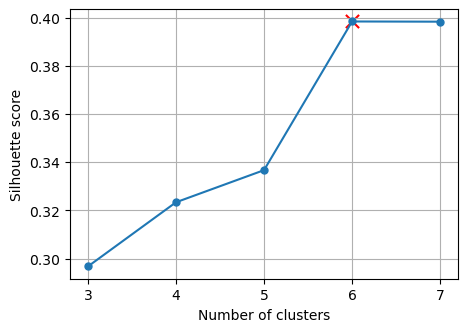

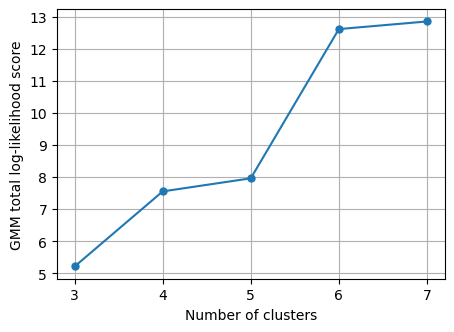

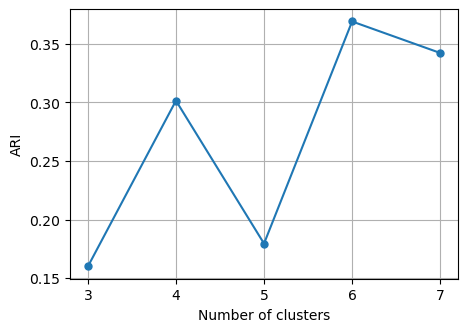

In [16]:
# Plot
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list_gmm_kmeans, shs_list_gmm_kmeans, marker='o', markersize=5)
plt.scatter(best_n_gmm_kmeans, best_sh_gmm_kmeans, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.xticks(np.arange(min(n_cluster_list_gmm_kmeans), max(n_cluster_list_gmm_kmeans)+1, 1.0))
plt.show()

# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list_gmm_kmeans, log_l_list_gmm_kmeans, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.xticks(np.arange(min(n_cluster_list_gmm_kmeans), max(n_cluster_list_gmm_kmeans)+1, 1.0))
plt.show()

# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list_gmm_kmeans, ari_list_gmm_kmeans, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.xticks(np.arange(min(n_cluster_list_gmm_kmeans), max(n_cluster_list_gmm_kmeans)+1, 1.0))
plt.show()

### 2.2 Second case: init_params = random

In [17]:
%%time

#GaussianMixture
#In this case use as hyper-parameter init_params = random

#We compute the different scores for each iteration

#print(X_s)
#print(y)

# Arrays init
n_cluster_list_gmm_random = []
shs_list_gmm_random = []
ri_list_gmm_random = []
ari_list_gmm_random = []
log_l_list_gmm_random = []

# Define the range for initial search
initial_search_range = range(3, 16, 3)  # Larger step size

# Use Parallel and delayed to parallelize the initial search
results_gmm_random = Parallel(n_jobs=-1)(
    delayed(perform_gmm_clustering)(n_clusters, X_s, y, 'random') for n_clusters in initial_search_range)

n_cluster_list_gmm_random, shs_list_gmm_random, ri_list_gmm_random, ari_list_gmm_random, log_l_list_gmm_random = zip(
    *results_gmm_random)

# Find the best initial k
best_sh_gmm_random = np.max(shs_list_gmm_random)
best_n_gmm_random = n_cluster_list_gmm_random[np.argmax(shs_list_gmm_random)]

print("Best initial k: ", best_n_gmm_random, " with corresponding silhouette: ", best_sh_gmm_random)
# Best refined k:  3  with corresponding silhouette:  0.44878078445247965

# Refine search around the best k found
refined_n_cluster_list_gmm_random = []
refined_shs_list_gmm_random = []
refined_ri_list_gmm_random = []
refined_ari_list_gmm_random = []
refined_log_l_list_gmm_random = []

# Define the refined range
refined_range = range(max(3, best_n_gmm_random - 2), min(16, best_n_gmm_random + 3))

# Use Parallel and delayed to parallelize the loop for the refined search
results_refined_gmm_random = Parallel(n_jobs=-1)(
    delayed(perform_gmm_clustering)(n_clusters, X_s, y, 'random') for n_clusters in refined_range)

refined_n_cluster_list_gmm_random, refined_shs_list_gmm_random, refined_ri_list_gmm_random, refined_ari_list_gmm_random, refined_log_l_list_gmm_random = zip(
    *results_refined_gmm_random)

# Find the best refined k
best_refined_sh_gmm_random = np.max(refined_shs_list_gmm_random)
best_refined_n_gmm_random = refined_n_cluster_list_gmm_random[np.argmax(refined_shs_list_gmm_random)]
best_refined_gmm_random = np.array([best_refined_sh_gmm_random, best_refined_n_gmm_random])
print("Best refined k: ", best_refined_n_gmm_random, " with corresponding silhouette: ", best_refined_sh_gmm_random)
# Best refined k:  5  with corresponding silhouette:  0.4102666682711448

Best initial k:  3  with corresponding silhouette:  0.3603249611170074
Best refined k:  5  with corresponding silhouette:  0.4102666682711448
CPU times: user 89 ms, sys: 103 ms, total: 192 ms
Wall time: 1min 54s


#### Plots of Silhouette, Log-Likihood score and ARI


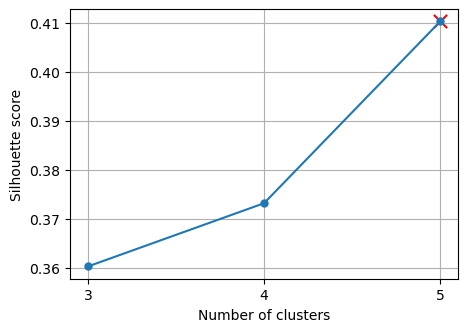

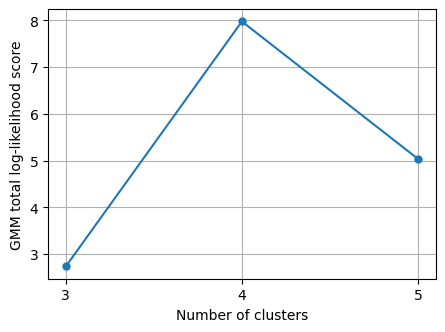

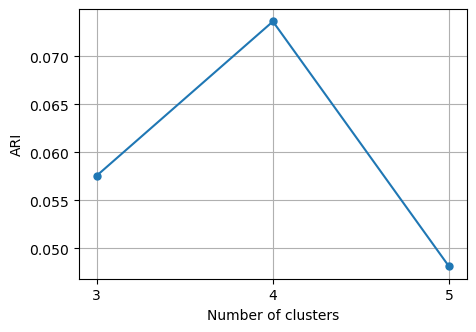

In [18]:
# Plot
plt.figure(figsize=(5, 3.5))
plt.plot(refined_n_cluster_list_gmm_random, refined_shs_list_gmm_random, marker='o', markersize=5)
plt.scatter(best_refined_n_gmm_random, best_refined_sh_gmm_random, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.xticks(np.arange(min(refined_n_cluster_list_gmm_random), max(refined_n_cluster_list_gmm_random)+1, 1.0))
plt.show()

# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(refined_n_cluster_list_gmm_random, refined_log_l_list_gmm_random, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.xticks(np.arange(min(refined_n_cluster_list_gmm_random), max(refined_n_cluster_list_gmm_random)+1, 1.0))
plt.show()

# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(refined_n_cluster_list_gmm_random, refined_ari_list_gmm_random, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.xticks(np.arange(min(refined_n_cluster_list_gmm_random), max(refined_n_cluster_list_gmm_random)+1, 1.0))
plt.show()


## Conclusions

In this section, we decide which is the best method of clustering, and with which k.

In [19]:
# Comparing the silhouette scores
scores = {
    "KMeans (Refined)": best_refined_kmeans[0],
    "GMM (KMeans Init)": best_gmm_kmeans[0],
    "GMM (Random Init)": best_refined_gmm_random[0]
}

# Find the algorithm with the highest score
best_algorithm = max(scores, key=scores.get)
best_score = scores[best_algorithm]

# Output the best algorithm and its score
print(f"The best clustering algorithm is {best_algorithm} with a silhouette score of {best_score}.")

# If needed, output the corresponding number of clusters
if best_algorithm == "KMeans (Refined)":
    best_n = best_refined_kmeans[1]
elif best_algorithm == "GMM (KMeans Init)":
    best_n = best_gmm_kmeans[1]
else:
    best_n = best_refined_gmm_random[1]

best_n = int(best_n)
print(f"The optimal number of clusters for {best_algorithm} is {best_n}.")

The best clustering algorithm is KMeans (Refined) with a silhouette score of 0.5376187674752735.
The optimal number of clusters for KMeans (Refined) is 14.


# Section 4
## 4.1  Do clusters reflect the GT labels ?

We use the data and the results of the k-means attempt

In [20]:
%%time

#best_n = 14 This variable could be used as hard-coded if we don't want to execute all the notebook.

# Let's use KMeans (we said that is the best)

best_refined_n_kmeans = int(best_n)
model = KMeans(n_clusters=best_refined_n_kmeans, random_state=42)
cluster_labels = model.fit_predict(X_s)

# Calculate clustering metrics
silhouette = silhouette_score(X_s, cluster_labels)
ari = adjusted_rand_score(np.ravel(y), cluster_labels)

print(f"Silhouette Score: {silhouette}")
print(f"Adjusted Rand Index: {ari}")
print(f"The ideal number of clusters is {best_refined_n_kmeans} and the number of different GT labels is 12")

Silhouette Score: 0.5376187674752735
Adjusted Rand Index: 0.3472982159289136
The ideal number of clusters is 14 and the number of different GT labels is 12
CPU times: user 2min 23s, sys: 6min 24s, total: 8min 47s
Wall time: 1min 35s


## 4.1  What is ECDF of number of clusters assigned to each class?

In [21]:
# Find the index of best_refined_n in refined_n_cluster_list

best_refined_index = refined_n_cluster_list_kmeans.index(best_refined_n_kmeans)

# Use this index to get the corresponding cluster labels
best_refined_cl_labels = refined_cl_labels_list_kmeans[best_refined_index]

# best_refined_cl_labels now contains the cluster labels for the best refined clustering
ddos_tmp = ddos_data_original.copy()
ddos_tmp['assigned_cluster'] = best_refined_cl_labels

# Group by 'label' and count unique clusters for each label
unique_clusters_per_label = ddos_tmp.groupby('label')['assigned_cluster'].nunique()

# Create a new DataFrame from the result
label_cluster_count_df = unique_clusters_per_label.reset_index()
label_cluster_count_df.columns = ['Label', '']

# Calculate the number of samples for each label
sample_counts = ddos_data['label'].value_counts()

# Convert the number of samples in a dataframe
sample_counts_df = sample_counts.reset_index()
sample_counts_df.columns = ['Label', 'Sample_Count']

label_cluster_count_df = pd.merge(label_cluster_count_df, sample_counts_df, on='Label')

In [22]:
plt.figure(figsize=(8, 5))
sns.ecdfplot(data=label_cluster_count_df, x='Unique_Clusters_Count')
plt.title(' ECDF of number of clusters assigned to each class')
plt.xlabel('Number of clusters')
plt.ylabel('ECDF')
plt.yticks(np.arange(0, 1.1, 0.1))  # This sets y-ticks at intervals of 0.1
plt.grid(True)
plt.show()

ValueError: Could not interpret value `Unique_Clusters_Count` for parameter `x`

<Figure size 800x500 with 0 Axes>

In [23]:
%%time


# Analizza il numero di flussi per cluster Analize the number of flows per class
cluster_df = pd.DataFrame({'Cluster': cluster_labels, 'NumFlows': ddos_data.index}).reset_index()

CPU times: user 3.57 ms, sys: 6.9 ms, total: 10.5 ms
Wall time: 9.31 ms


In [ ]:
%%time

# Plot ECDF per il numero di flussi per cluster
#plt.figure(figsize=(8, 5))
#sns.ecdfplot(data=cluster_df, x='NumFlows', hue='Cluster',palette='coolwarm')
#plt.title('ECDF of Number of Flows per Cluster')
#plt.xlabel('Number of Flows')
#plt.ylabel('ECDF')
#plt.show()

## 4.1   Are there pure clusters where all elements belong to a single class and there is benign traffic with similar characteristics to malicious one?
<a id='my_anchor'></a>
This analysis can reveal patterns in the data, such as which clusters predominantly contain benign instances or specific types of DDoS attacks.



In [24]:
# Create a DataFrame combining cluster labels and actual data labels
y_ = y.ravel()
data = {'Cluster_Labels': cluster_labels, 'Real_Labels': y_}
df_ = pd.DataFrame(data)

# Function to count labels within each cluster
def count_labels(cluster_group):
    benign_count = cluster_group[cluster_group == 'benign'].count()
    ddos_counts = cluster_group[cluster_group.str.startswith('ddos_')].value_counts()
    return benign_count, ddos_counts

# Apply the function to each cluster group
cluster_info = df_.groupby('Cluster_Labels')['Real_Labels'].apply(count_labels)


# Display the results
for cluster, (benign_count, ddos_counts) in cluster_info.items():
    print(f"Cluster {cluster}:")
    print("DDoS list:")

    # Print each ddos_count with its label
    tot_count = 0
    for label, count in ddos_counts.items():
        tot_count+=count
        print(f"-{label}: {count}")
    print(f"---Malign Ddos total count: {tot_count}")
    print(f"---Benign Count: {benign_count}")
    print("\n")


Cluster 0:
DDoS list:
-ddos_tftp: 5192
-ddos_syn: 3167
-ddos_ntp: 76
-ddos_dns: 15
---Malign Ddos total count: 8450
---Benign Count: 52


Cluster 1:
DDoS list:
-ddos_mssql: 5728
-ddos_ssdp: 5573
-ddos_ldap: 5421
-ddos_dns: 585
-ddos_netbios: 412
-ddos_udp: 2
---Malign Ddos total count: 17721
---Benign Count: 1


Cluster 2:
DDoS list:
-ddos_ntp: 607
-ddos_dns: 81
-ddos_ssdp: 2
-ddos_tftp: 2
-ddos_ldap: 1
---Malign Ddos total count: 693
---Benign Count: 1632


Cluster 3:
DDoS list:
-ddos_udp_lag: 5986
-ddos_snmp: 5984
-ddos_udp: 5873
-ddos_netbios: 4700
-ddos_dns: 463
-ddos_ssdp: 44
-ddos_ntp: 14
-ddos_mssql: 8
-ddos_ldap: 4
-ddos_tftp: 3
---Malign Ddos total count: 23079
---Benign Count: 248


Cluster 4:
DDoS list:
-ddos_ntp: 3
-ddos_dns: 1
---Malign Ddos total count: 4
---Benign Count: 359


Cluster 5:
DDoS list:
---Malign Ddos total count: 0
---Benign Count: 2142


Cluster 6:
DDoS list:
-ddos_ldap: 1
-ddos_mssql: 1
-ddos_netbios: 1
-ddos_ssdp: 1
-ddos_udp: 1
-ddos_tftp: 1
---Malign Dd

## 4.2 What are the most important features in the obtained clusters?


In [25]:
%%time
! pip3 install xgboost


import xgboost as xgb

# Prepara i tuoi dati
X = ddos_data.drop(columns=['label'])
y = cluster_labels

# Addestra un classificatore con xgboost
model = xgb.XGBClassifier(random_state=42)
model.fit(X, y)

# Crea un oggetto explainer SHAP e calcola i valori SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

  Using cached xgboost-1.6.2-py3-none-manylinux2014_x86_64.whl (255.9 MB)
CPU times: user 2min 43s, sys: 0 ns, total: 2min 43s
Wall time: 30.2 s


# 4.3, 4.4 Descriptive Analysis for Features
Can you spot sub-attacks? Because of which feature? Can you find new groups or
similar clusters? Why? According to which feature? <br>
Which of the attacks are more similar? According to which feature?

Centroidi del cluster:
                        0          1          2          3          4  \
Cluster_Labels                                                          
0                1.135771  -0.681904  -1.796811  -0.737406   0.044479   
1               -1.951143   0.984057   0.899804  -0.291041   0.272866   
2                4.855000  -2.279639   5.162536  -0.042921   0.801033   
3               -0.253034  -0.535174  -0.351014  -0.271933   0.032150   
4                8.176104   9.692773  -3.027565   1.430523   0.687329   
5                3.431481  -0.889643   1.339054  -0.540890  -1.664666   
6               13.510720  10.298003   2.151343  11.398663  35.472919   
7               -0.242654  -0.731571  -0.256978   2.754063  -0.654963   
8                5.095860   5.596923  -0.529679  -0.386875  -1.553754   
9               -1.781923   0.491230   0.616983   1.790510  -0.440848   
10              -0.770024  -1.017499  -0.146352   9.774765  -2.941792   
11               4.431614  -

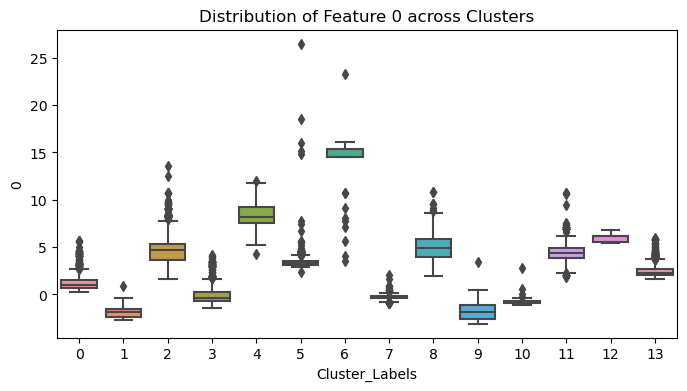

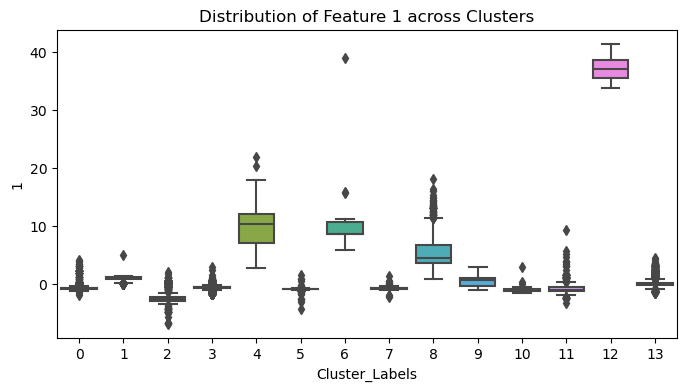

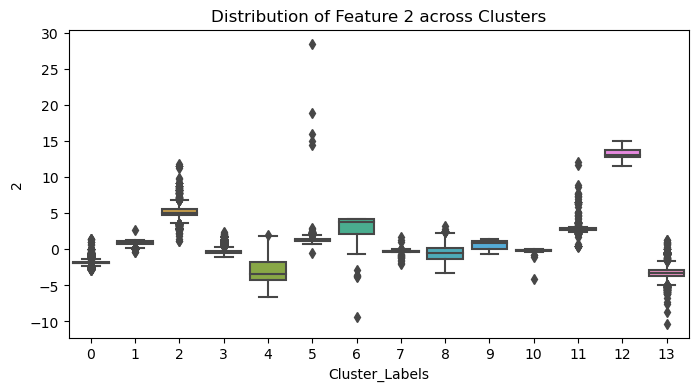

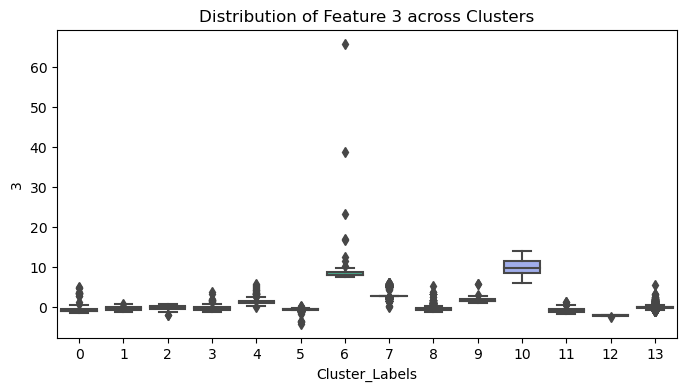

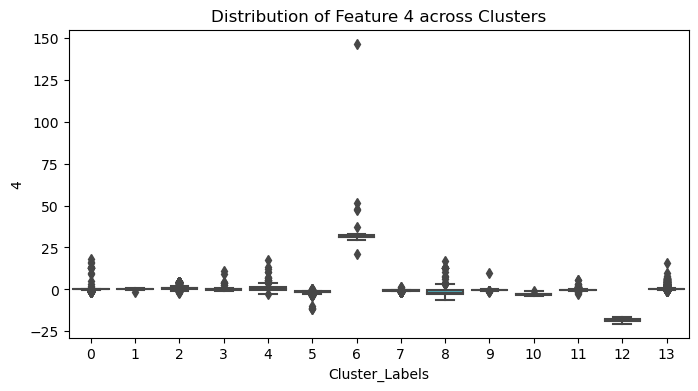

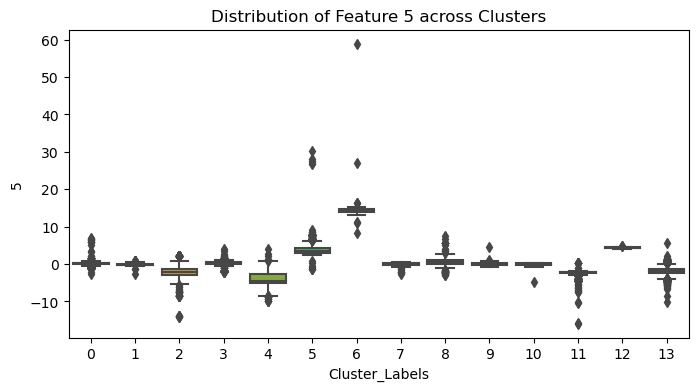

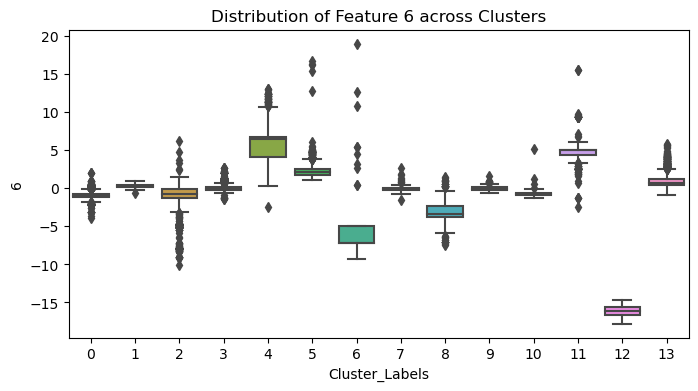

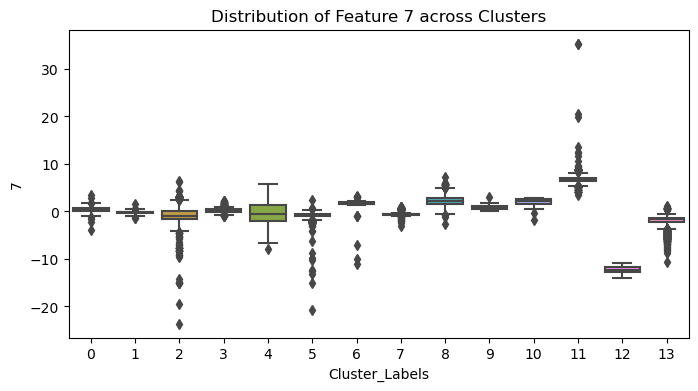

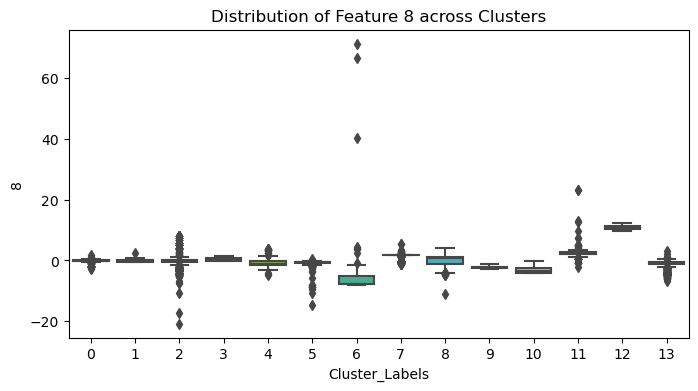

In [60]:
X_df = pd.DataFrame(X_s)
X_df['Cluster_Labels'] = cluster_labels

# Calculate cluster centroids
centroids = X_df.groupby('Cluster_Labels').mean()

# Print cluster centroids
print("Centroidi del cluster:")
print(centroids)

# For each feature, create a boxplot for each cluster
for i in range(X_df.shape[1]-1):  # no 'Cluster_Labels'
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Cluster_Labels', y=i, data=X_df)
    plt.title(f'Distribution of Feature {i} across Clusters')
    plt.show()

According to these boxplots and to the statistics provided in the ["4.1 Are there pure clusters where all elements belong to a single class and there is benign traffic with similar characteristics to malicious one?"](#my_anchor)
 section, and by conducting a cross-analysis, we can draw significant insights into the potential sub-attacks:
* Cluster 0 and Cluster 13: Both clusters have ‘ddos_syn’ and ‘ddos_dns’ attacks, but the counts are different. Cluster 0 has 3167 ‘ddos_syn’ and 15 ‘ddos_dns’ attacks, while Cluster 13 has 2313 ‘ddos_syn’ and 1 ‘ddos_dns’ attack. This could potentially indicate two sub-attacks of ‘ddos_syn’ and ‘ddos_dns’ attacks. 

* Cluster 1 and Cluster 9: Both clusters have ‘ddos_ldap’, ‘ddos_ssdp’, ‘ddos_mssql’, and ‘ddos_dns’ attacks. However, the counts are different. For example, Cluster 1 has 5421 ‘ddos_ldap’ attacks while Cluster 9 has 500 ‘ddos_ldap’ attacks. This could potentially indicate two sub-attacks of ‘ddos_ldap’, ‘ddos_ssdp’, ‘ddos_mssql’, and ‘ddos_dns’ attacks.

* Cluster 3 and Cluster 5: Cluster 3 has a variety of DDoS attacks, while Cluster 5 doesn’t have any. This could indicate that Cluster 3 represents a more aggressive form of DDoS attacks, while Cluster 5 represents benign traffic.

* Cluster 2 and Cluster 8: Both clusters have ‘ddos_ntp’ and ‘ddos_dns’ attacks. However, the counts are different. For instance, Cluster 2 has 607 ‘ddos_ntp’ and 81 ‘ddos_dns’ attacks, while Cluster 8 has 276 ‘ddos_ntp’ and 37 ‘ddos_dns’ attacks. This could potentially indicate two sub-attacks of ‘ddos_ntp’ and ‘ddos_dns’ attacks.

* Cluster 1 and Cluster 7: Both clusters have ‘ddos_dns’ attacks but with different counts. Cluster 1 has 585 ‘ddos_dns’ attacks while Cluster 7 has 3473 ‘ddos_dns’ attacks. This could potentially indicate two sub-attacks of ‘ddos_dns’ attacks.

* Cluster 3 and Cluster 9: Both clusters have ‘ddos_netbios’ attacks. However, the counts are different. Cluster 3 has 4700 ‘ddos_netbios’ attacks while Cluster 9 has 717 ‘ddos_netbios’ attacks. This could potentially indicate two sub-attacks of ‘ddos_netbios’ attacks.

Cluster 0


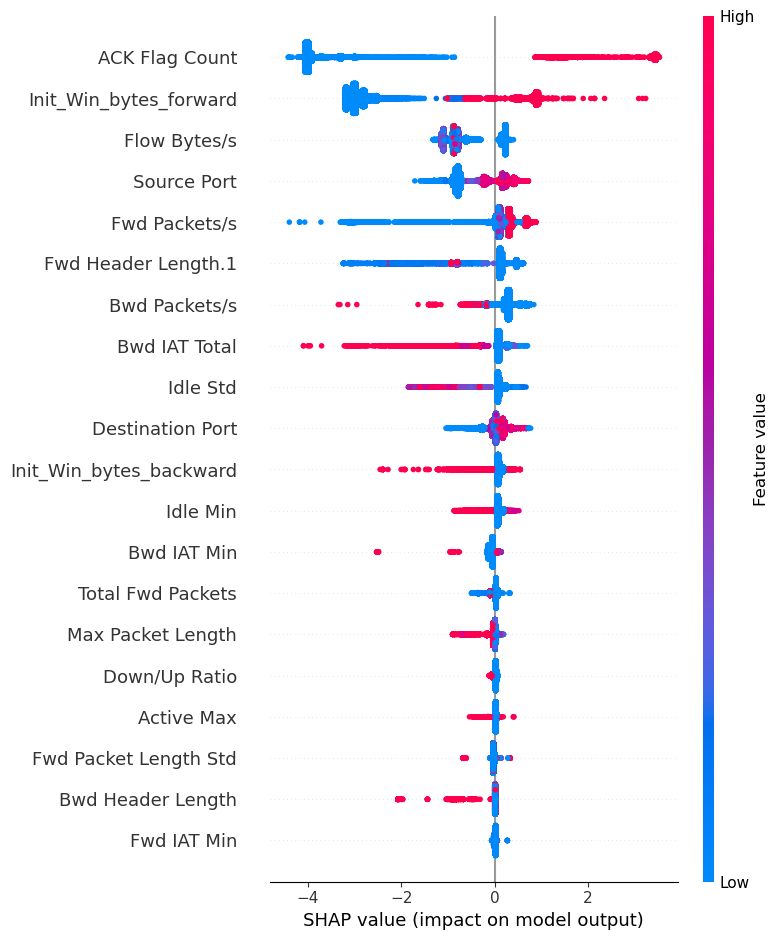

Cluster 1


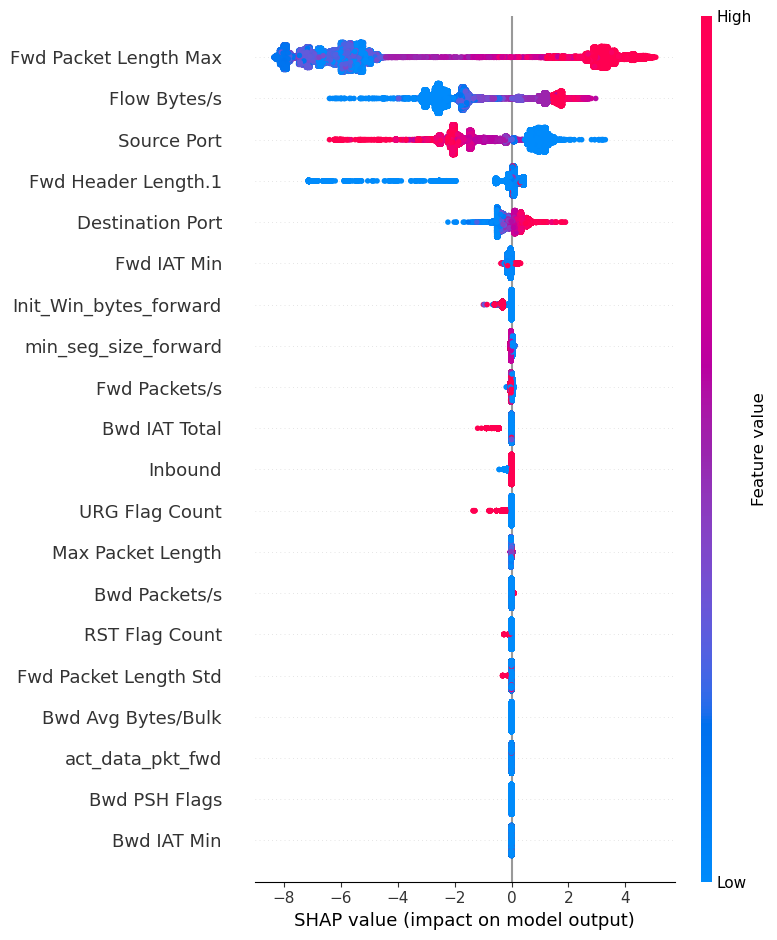

Cluster 2


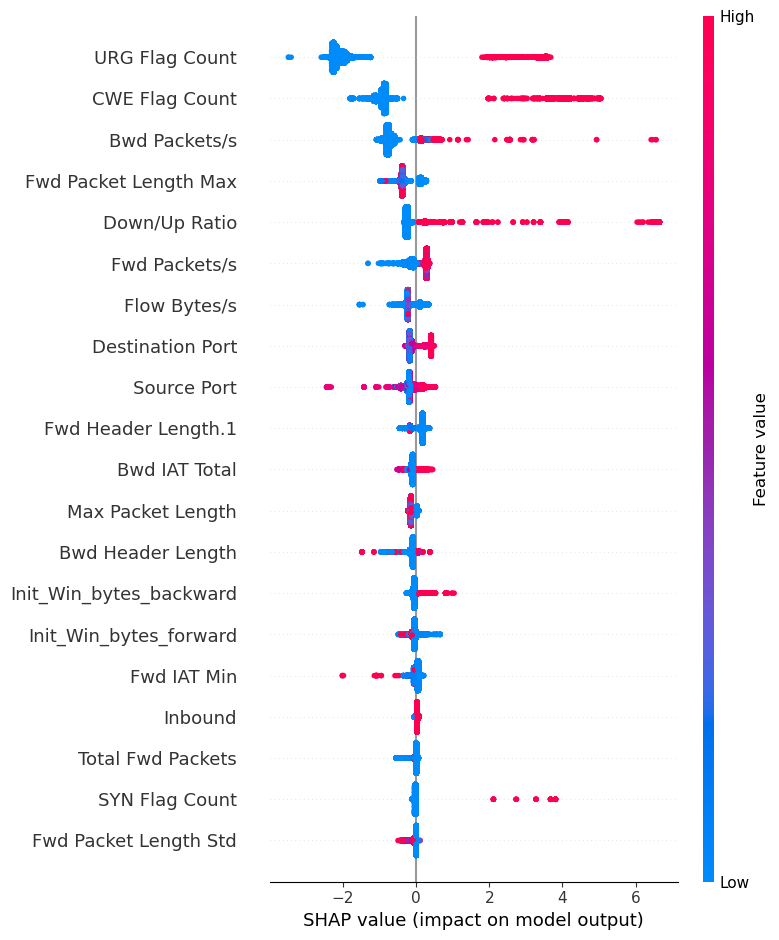

Cluster 3


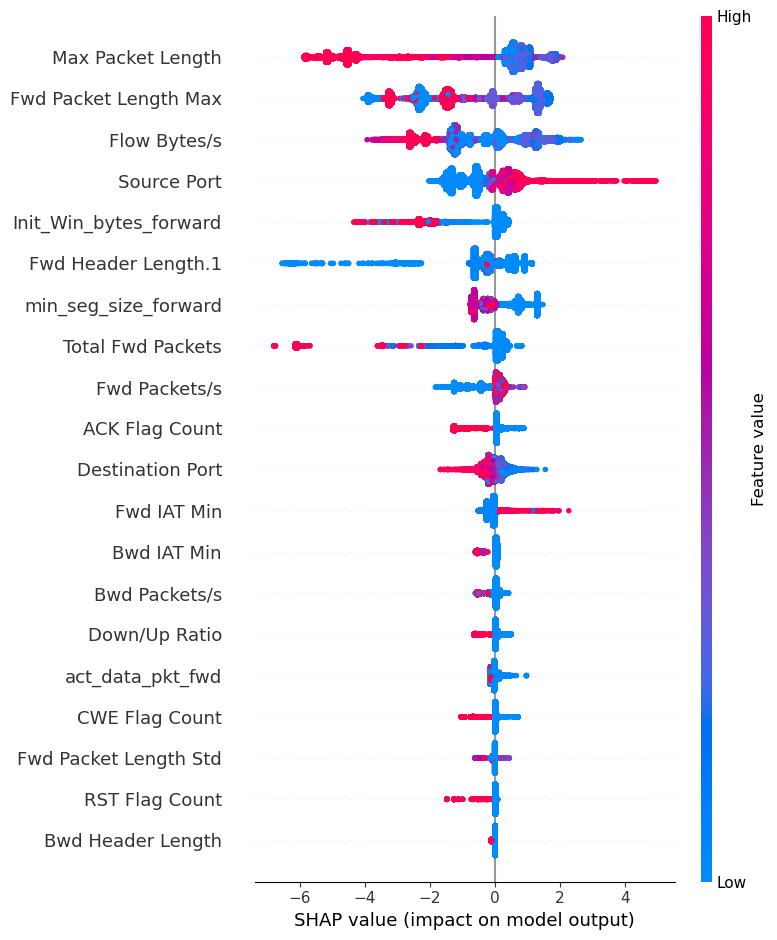

Cluster 4


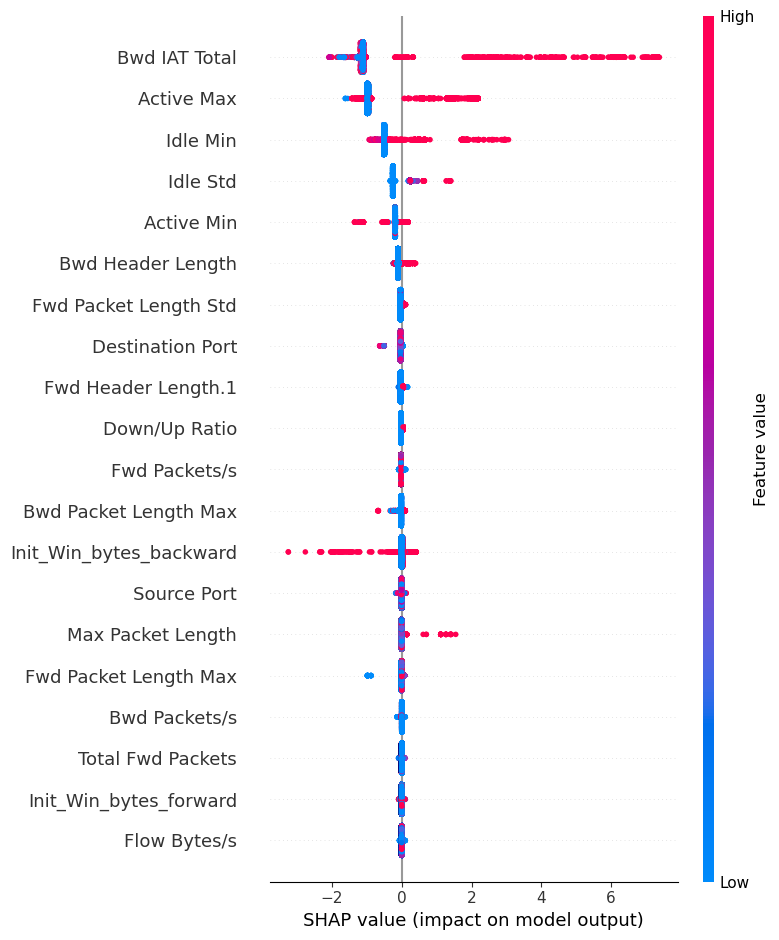

Cluster 5


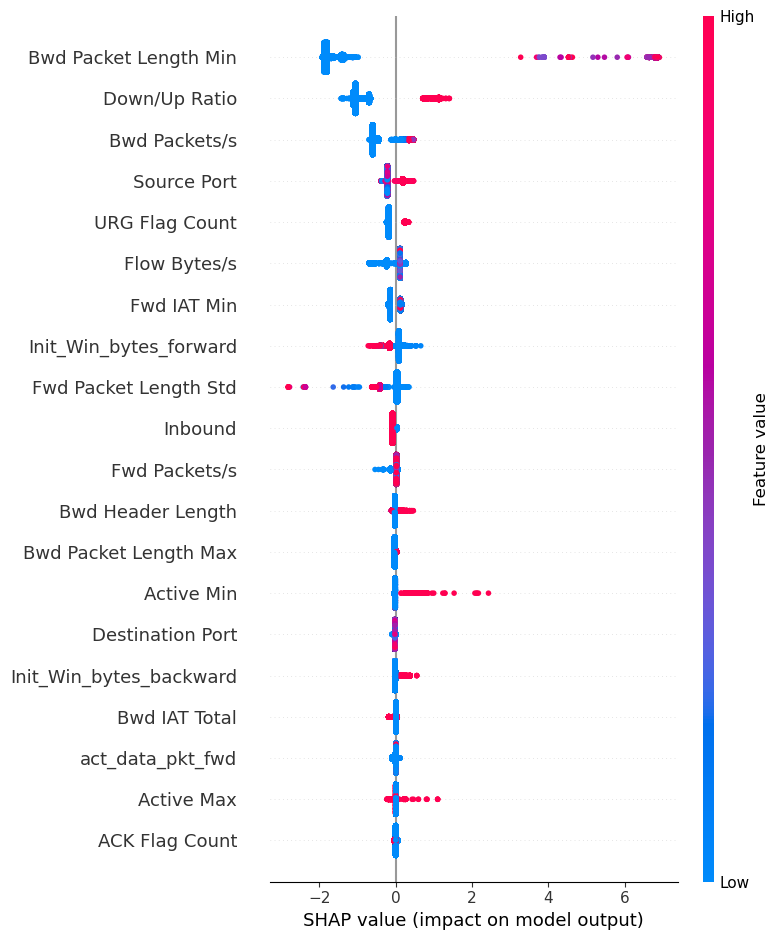

Cluster 6


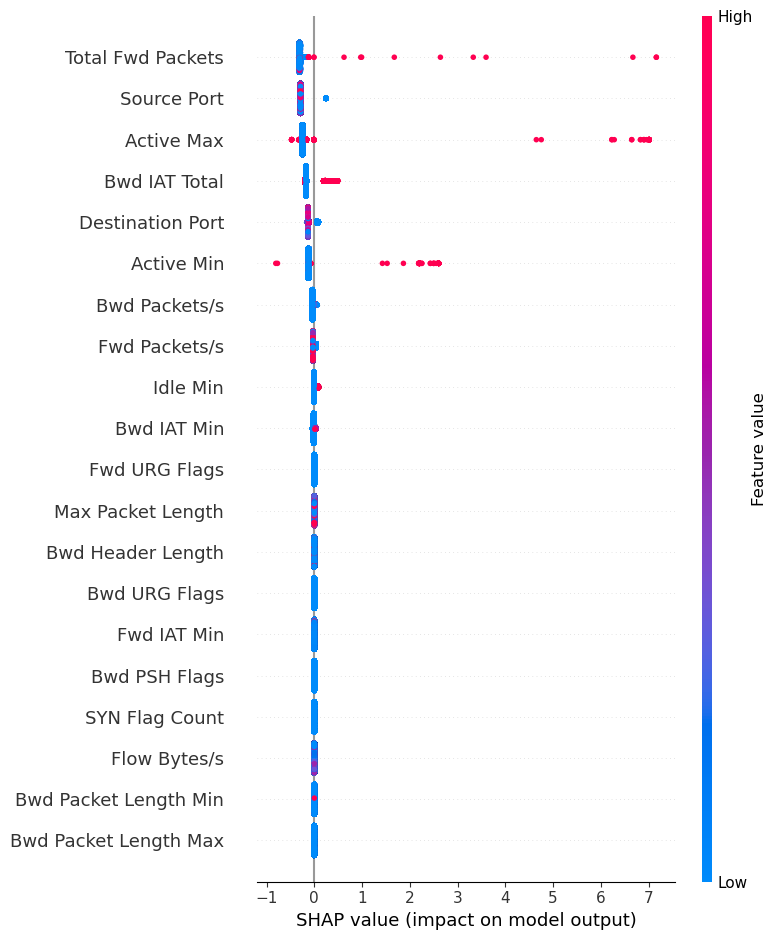

Cluster 7


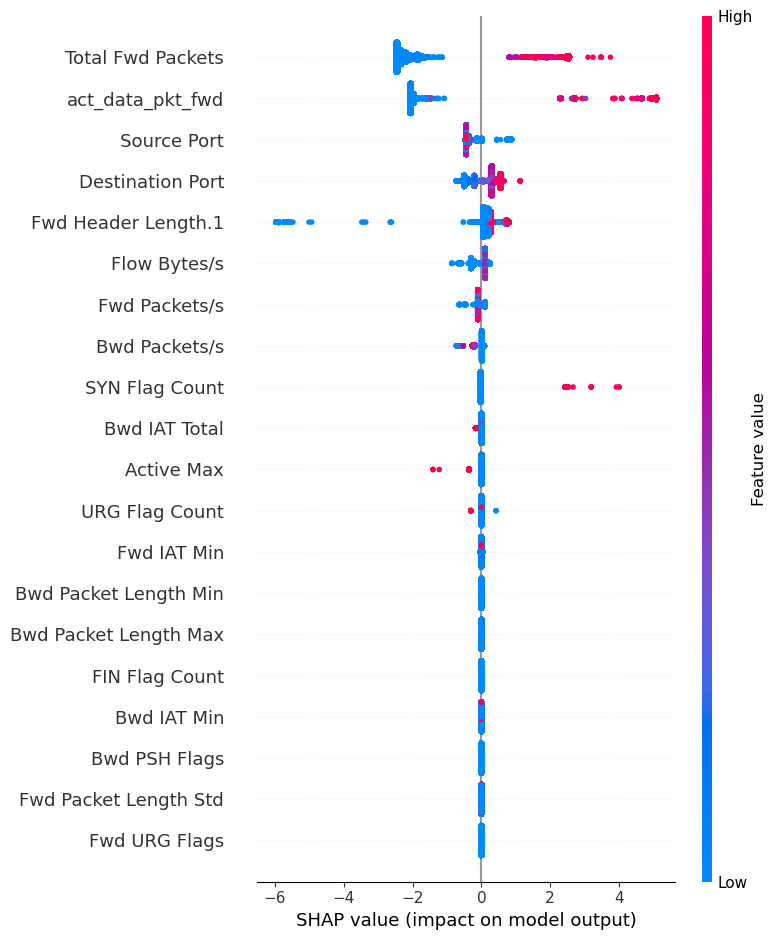

Cluster 8


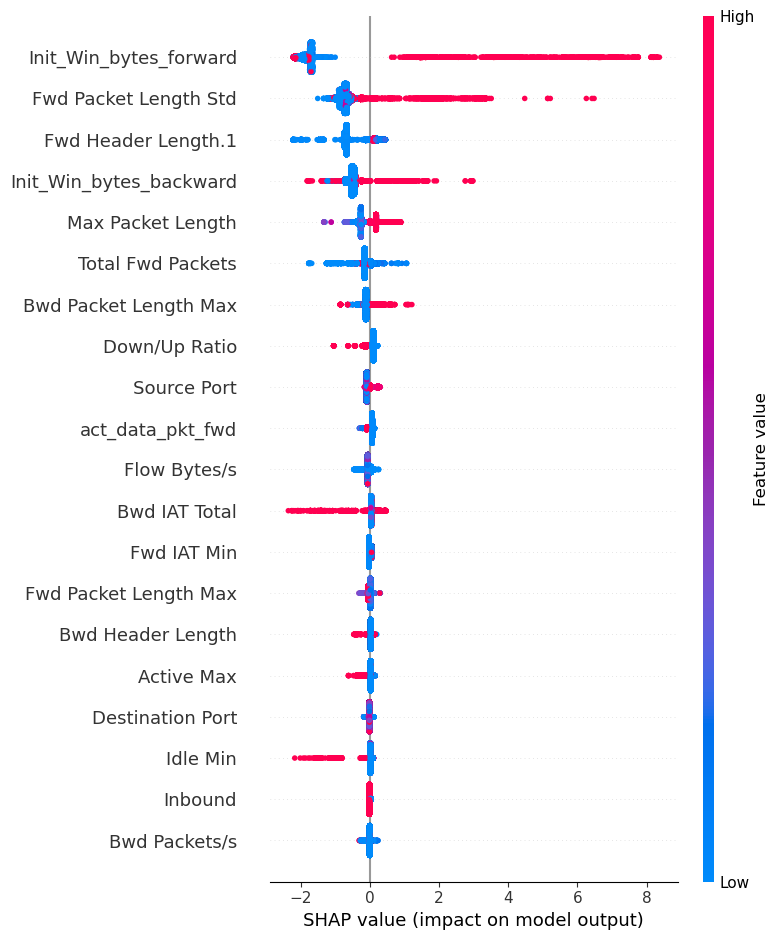

Cluster 9


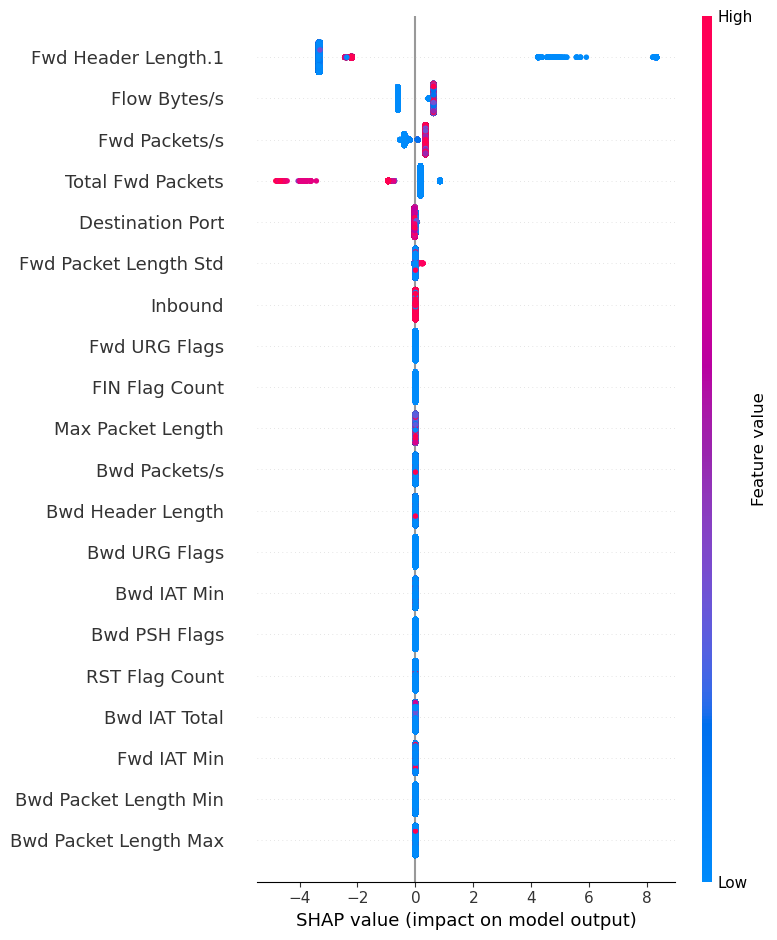

Cluster 10


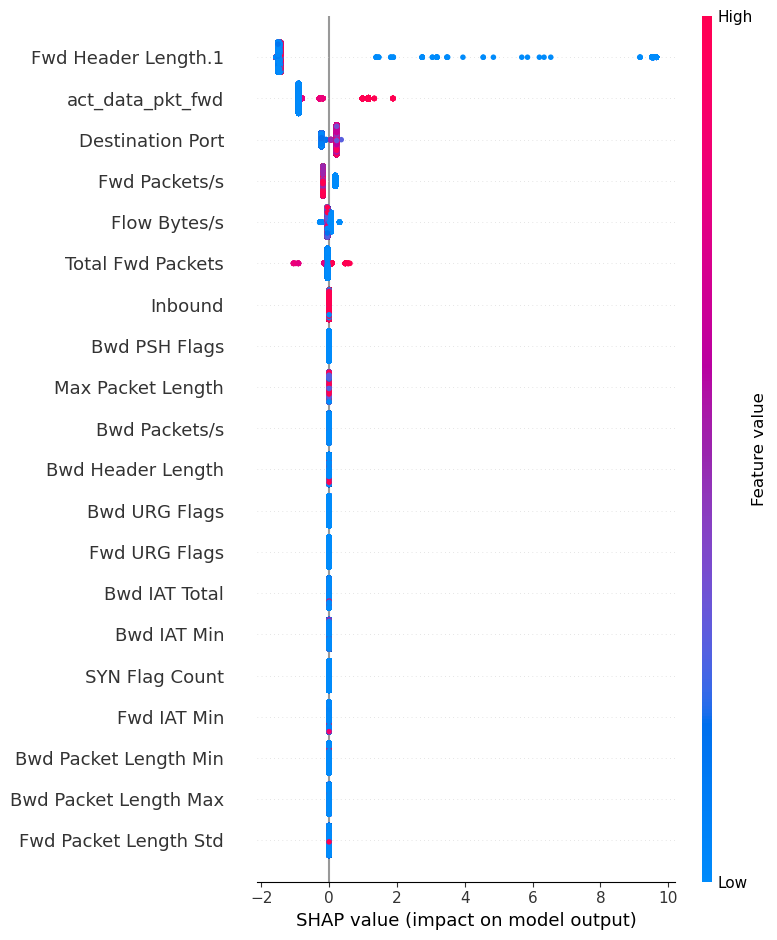

Cluster 11


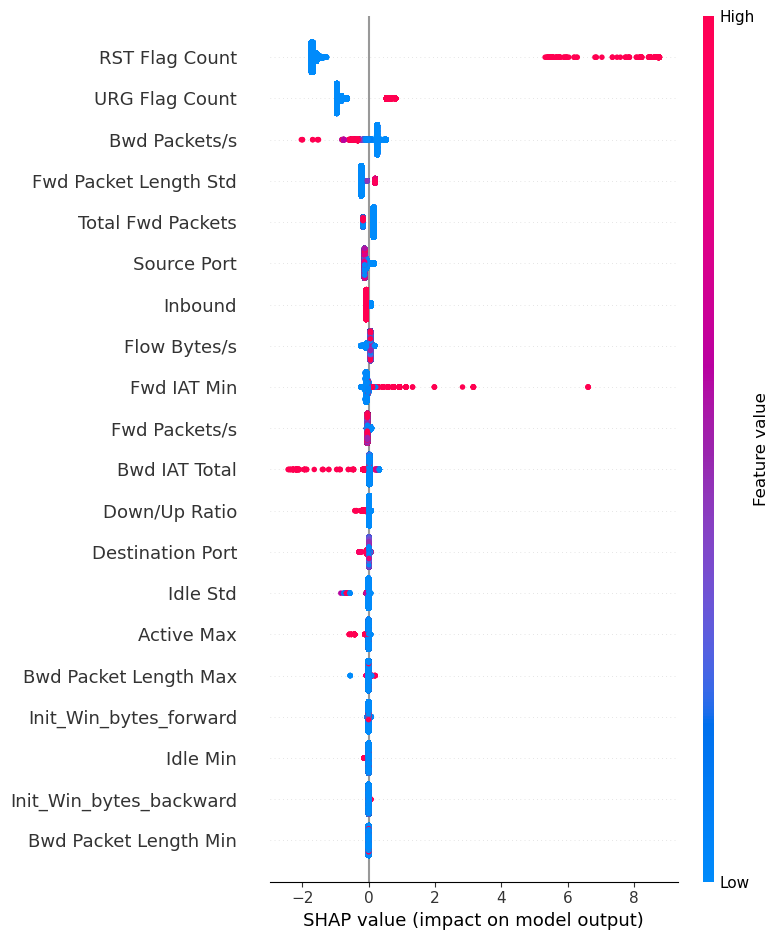

Cluster 12


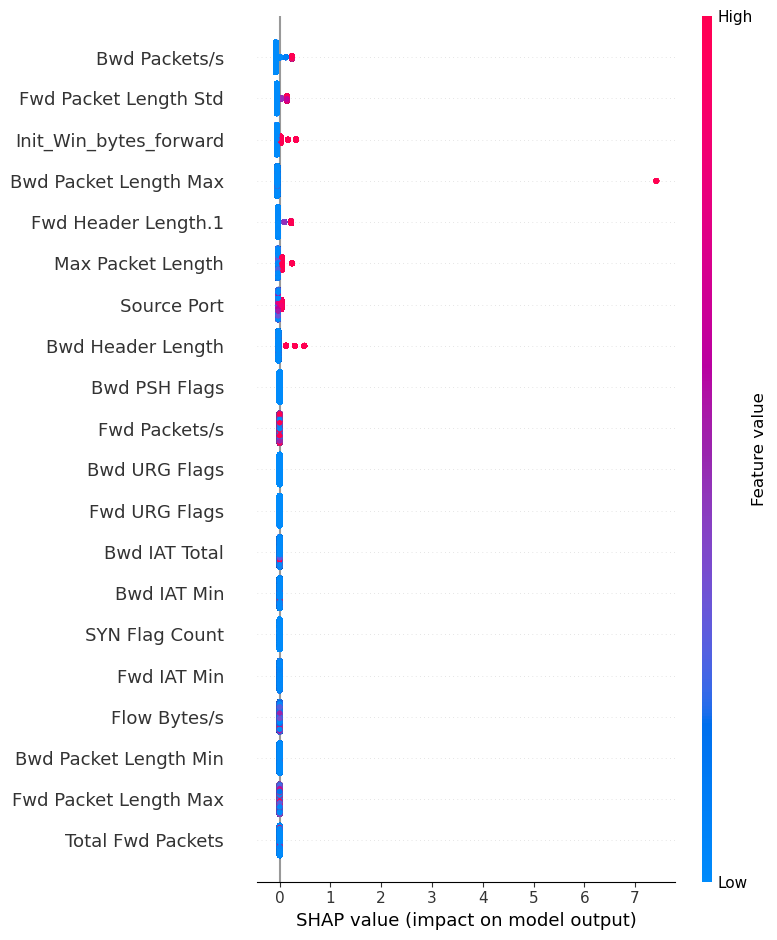

Cluster 13


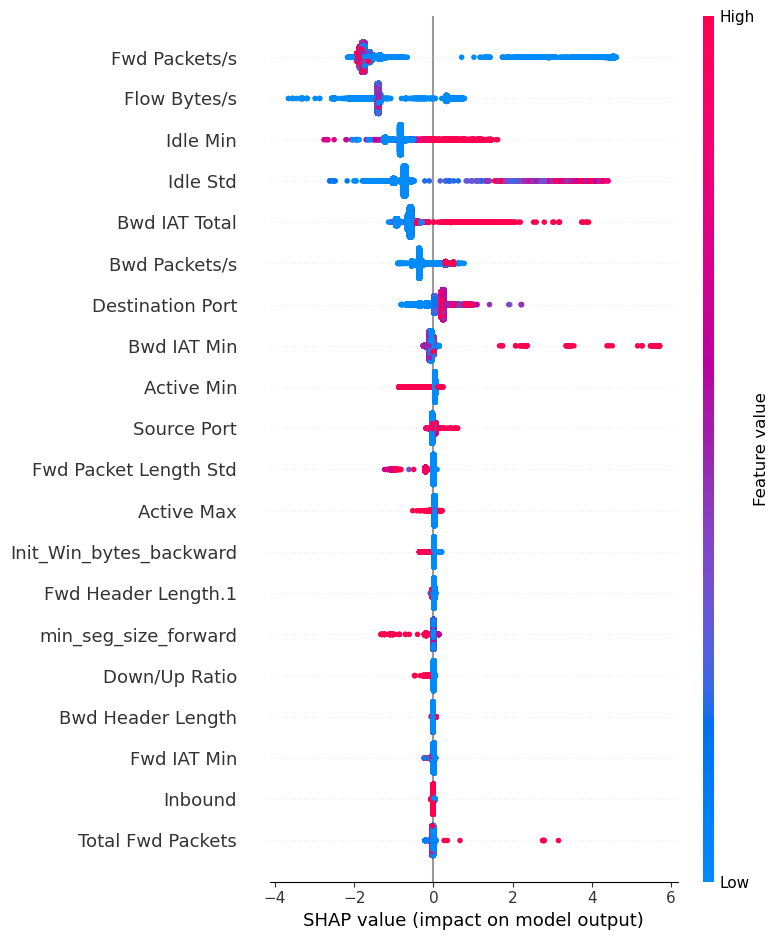

In [ ]:
# Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# For each cluster
for i in range(model.n_classes_):
    print(f"Cluster {i}")
    shap.summary_plot(shap_values[i], X)


Based on the provided SHAP (SHapley Additive exPlanations) plots and the cluster data, we can make the following observations:

+ Sub-Attacks Identification: A “sub-attack” can be considered as a specific type of DDoS attack that appears in more than one distinct cluster. For instance, ‘ddos_dns’ appears in Clusters 0, 1, 2, 3, 4, 7, 8, 9, and 10. This suggests that ‘ddos_dns’ might have different “sub-types”, each characterizing a different cluster.

* Feature Importance: The SHAP plots help identify the features that significantly impact the classification of clusters. These features could be useful in distinguishing between different sub-attacks. For example, in Cluster 0, ‘ACK Flag Count’ and ‘Init_Win_bytes_forward’ seem to have a significant impact, while in Cluster 1, ‘Fwd Packet Length Max’ has a notable positive impact.

* Similar Clusters Identification: Clusters having similar DDoS attack profiles could be considered as similar groups. For instance, Cluster 1 and Cluster 3 both have ‘ddos_mssql’ and ‘ddos_dns’ as common attacks. However, Cluster 3 has a much higher total number of attacks compared to Cluster 1, which might indicate that they are different despite the superficial similarity.

* Grouping Feature: The features that contribute most to the formation of clusters can be identified from the SHAP plots. For instance, in Cluster 0, ‘ACK Flag Count’ and ‘Init_Win_bytes_forward’ might be the key features for the formation of that cluster. In Cluster 1, ‘Fwd Packet Length Max’ seems to be the dominant feature.

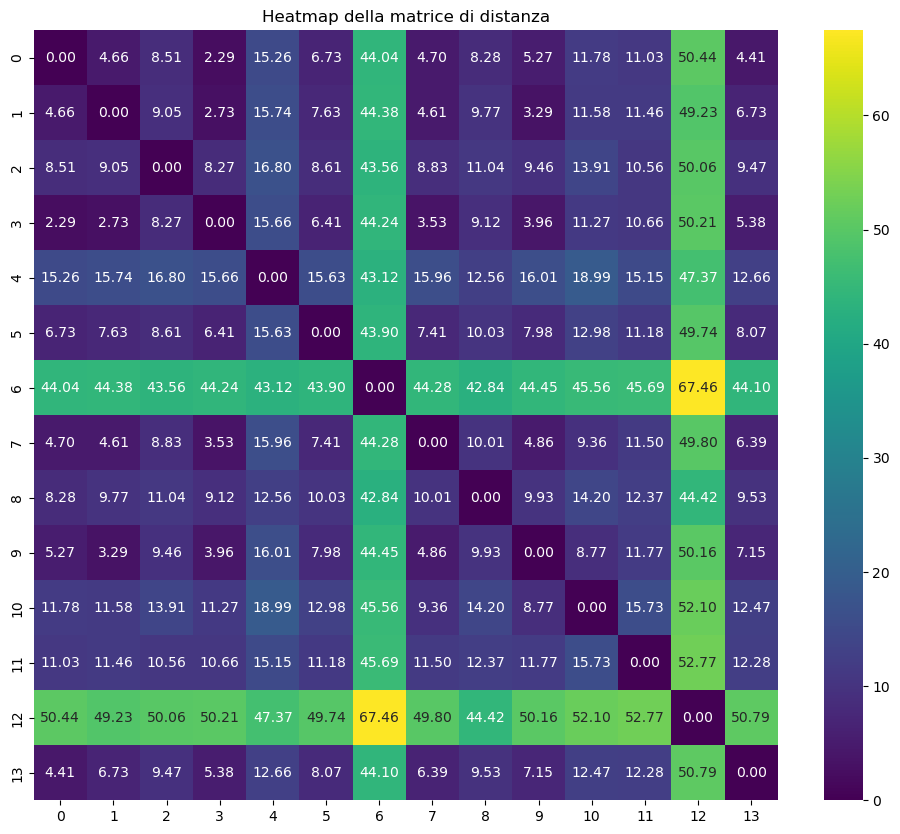

In [61]:
from scipy.spatial.distance import cdist

# Calculate cluster centroids
centroids = X_df.groupby('Cluster_Labels').mean()

# Calculate the distance matrix
dist_matrix = cdist(centroids, centroids)

# Create a heatmap of the distance matrix
plt.figure(figsize=(12, 10)) 
sns.heatmap(dist_matrix, annot=True, fmt=".2f", cmap='viridis')
plt.title('Heatmap della matrice di distanza')
plt.show()

The heatmap above is a visual representation of the distance matrix between the centroids of the clusters. The distance between centroids, calculated using the `cdist` function from the `scipy.spatial.distance` module, is a measure of dissimilarity between clusters.

Examining the heatmap, several observations can be made:

1. **Identifying Cluster Similarities**: Clusters that are close to each other in the feature space will have a smaller distance between them. For instance, the distance value between Cluster 0 and Cluster 1 is relatively small, indicating that these clusters might be similar to each other.

2. **Identifying Distinct Clusters**: Conversely, clusters that are far apart in the feature space will have a larger distance between them. For example, the distance value between Cluster 6 and Cluster 12 is quite large, suggesting a significant dissimilarity between these two clusters.

3. **Sub-Attack Identification**: If a specific type of DDoS attack appears in more than one distinct cluster, it might suggest that there are different "sub-types" of that attack, each characterizing a different cluster. For instance, if 'ddos_dns' appears in both Cluster 0 and Cluster 3, and these clusters are far apart in the heatmap, it indicates that 'ddos_dns' has different manifestations in the data, i.e., it has sub-attacks.